In [3]:
pip install scienceplots

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(['science','no-latex'])

head = "final_data/"
models = ["FFN","FFN2","SIREN"]
tail = "_comparison_results.csv"
avg_tail = "_avg.csv"

In [5]:
def mse_to_psnr(mse, max_pixel_value):
    return 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

def get_max_value(file_path):
    data = np.load("../"+file_path)
    return np.max(data)

def clean_data(model):
    filepath = os.path.abspath(head + model + tail)
    data = pd.read_csv(filepath)
    data['original_psnr'] = np.nan
    for index, row in data.iterrows():
        max_value = get_max_value(row['file_name'])
        psnr = mse_to_psnr(row['original_mse'], max_value)
        data.at[index, 'original_psnr'] = psnr
    data = data.drop(["in_features","out_features","device"],axis=1)
    data.to_csv(head + model + tail, index=False)

In [34]:
def reshape_data(data, target_shape):
    """
    Reshape the data to the target shape by selecting every other point along reduced dimensions.
    
    :param data: numpy array of shape (192, 249, 16)
    :param target_shape: tuple of the desired shape
    :return: reshaped numpy array
    """
    original_shape = (192, 249, 16)
    
    if data.shape != original_shape:
        raise ValueError(f"Input data must have shape {original_shape}")

    if original_shape == target_shape:
        return data
    
    if target_shape not in [(192, 125, 16), (192, 249, 8), (96, 125, 16), (96, 125, 8)]:
        raise ValueError("Target shape must be one of (192, 125, 16), (192, 249, 8), (96, 125, 16), or (96, 125, 8)")

    result = data.copy()

    # Reshape first dimension (192 -> 96)
    if target_shape[0] == 96:
        result = result[::2, :, :]

    # Reshape second dimension (249 -> 125)
    if target_shape[1] == 125:
        result = result[:, ::2, :]

    # Reshape third dimension (16 -> 8)
    if target_shape[2] == 8:
        result = result[:, :, ::2]

    return result

In [7]:
def get_averages(df):
    columns_to_average = ['original_mse', 'compression_ratio', 'transformed_mse', 'training_time', 'original_psnr']
    columns_to_std = ['original_mse', 'training_time']
    group_by = ['lr', 'hidden_features', 'hidden_layers', 'max_iters']
    maybe = ["outermost_linear", "fourier_features","input_scale","weight_scale",'zero_percent','a','s','hidden_omega_zero','first_omega_zero','zero_fraction','refresh_interval','fraction','sample_fraction']
    
    for name in maybe:
        if name in df.columns:
            group_by.append(name)
    
    # Calculate means
    mean_agg_funcs = {col: 'mean' for col in columns_to_average}
    mean_agg_funcs['model'] = 'first'
    
    grouped_mean = df.groupby(group_by).agg(mean_agg_funcs).reset_index()

    # Calculate standard deviations
    std_agg_funcs = {col: 'std' for col in columns_to_std}
    
    grouped_std = df.groupby(group_by).agg(std_agg_funcs).reset_index()
    grouped_std = grouped_std.rename(columns={col: f'{col}_std' for col in columns_to_std})

    # Merge means and std deviations
    grouped = pd.merge(grouped_mean, grouped_std, on=group_by, how='left')

    return grouped

def add_averages(model):
    data = pd.read_csv(os.path.abspath(head + model + tail))
    average_df = get_averages(data)
    average_df.to_csv(head + model + "_avg.csv", index=False)

In [68]:
clean_data("SIREN_random_2000")
add_averages("SIREN_random_2000")

In [69]:
SIREN_importance_1000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_importance_1000" + avg_tail))
SIREN_random_1000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_random_1000" + avg_tail))
SIREN_zeros_1000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_zeros_1000" + avg_tail))
SIREN_normal_1000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_normal_1000" + avg_tail))
SIREN_normal_2000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_normal_2000" + avg_tail))
SIREN_zeros_2000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_zeros_2000" + avg_tail))
SIREN_importance_2000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_importance_2000" + avg_tail))
SIREN_random_2000_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_random_2000" + avg_tail))
SIREN_importance_same_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_same_importance" + avg_tail))
SIREN_random_same_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_same_random" + avg_tail))
SIREN_zeros_same_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_same_zeros" + avg_tail))
SIREN_normal_same_avg_data = pd.read_csv(os.path.abspath(head + "SIREN_same_normal" + avg_tail))

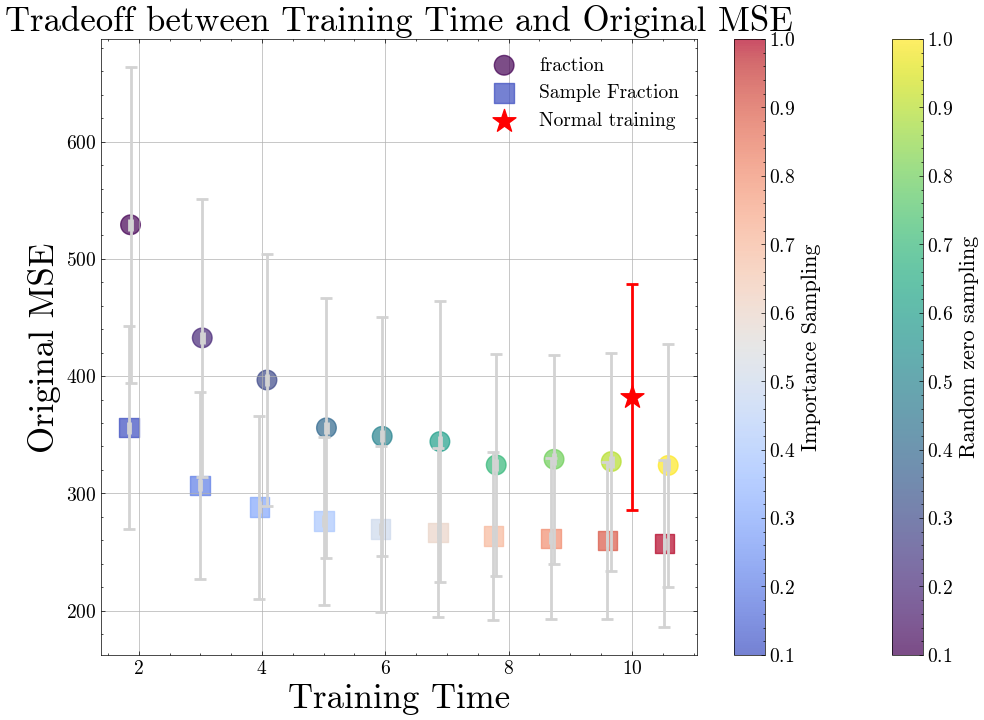

In [56]:
df1 = SIREN_random_1000_avg_data

# Second dataset
df2 = SIREN_importance_1000_avg_data

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for the first dataset with circle markers and error bars
scatter1 = plt.scatter(df1['training_time'], df1['original_mse'], 
                       c=df1['fraction'], cmap='viridis', s=200, alpha=0.7, label='fraction', marker='o')

# Adding error bars for the first dataset
plt.errorbar(df1['training_time'], df1['original_mse'], 
             xerr=df1['training_time_std'], yerr=df1['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Scatter plot for the second dataset with square markers and error bars
scatter2 = plt.scatter(df2['training_time'], df2['original_mse'], 
                       c=df2['sample_fraction'], cmap='coolwarm', s=200, alpha=0.7, label='Sample Fraction', marker='s')

# Adding error bars for the second dataset
plt.errorbar(df2['training_time'], df2['original_mse'], 
             xerr=df2['training_time_std'], yerr=df2['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Highlight a specific point with error bars
highlight_x = 10
highlight_y = 382
highlight_xerr = 0.0039  # Example standard deviation for training_time
highlight_yerr = 96.58  # Example standard deviation for original_mse

plt.scatter(highlight_x, highlight_y, color='red', s=300, marker='*', label='Normal training')
plt.errorbar(highlight_x, highlight_y, 
             xerr=highlight_xerr, yerr=highlight_yerr,
             fmt='none', ecolor='red', elinewidth=2, capsize=4, capthick=2)

# Adding labels and title with larger font size
plt.xlabel('Training Time', fontsize=25)
plt.ylabel('Original MSE', fontsize=25)
plt.title('Tradeoff between Training Time and Original MSE', fontsize=25)

# Adding color bars with larger font size
cbar1 = plt.colorbar(scatter1)
cbar1.set_label('Random zero sampling', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

cbar2 = plt.colorbar(scatter2)
cbar2.set_label('Importance Sampling', fontsize=16)
cbar2.ax.tick_params(labelsize=14)

# Setting tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True)
plt.show()


In [50]:
SIREN_normal_2000_avg_data

lr  hidden_features  hidden_layers  max_iters  outermost_linear  \
0  0.001              128              3       2000              True   

   hidden_omega_zero  first_omega_zero  original_mse  compression_ratio  \
0                 45               100    316.335318          22.721759   

   transformed_mse  training_time  original_psnr  model  original_mse_std  \
0         0.005248      20.262681      35.512124  SIREN        113.336801   

   training_time_std  
0           0.007929

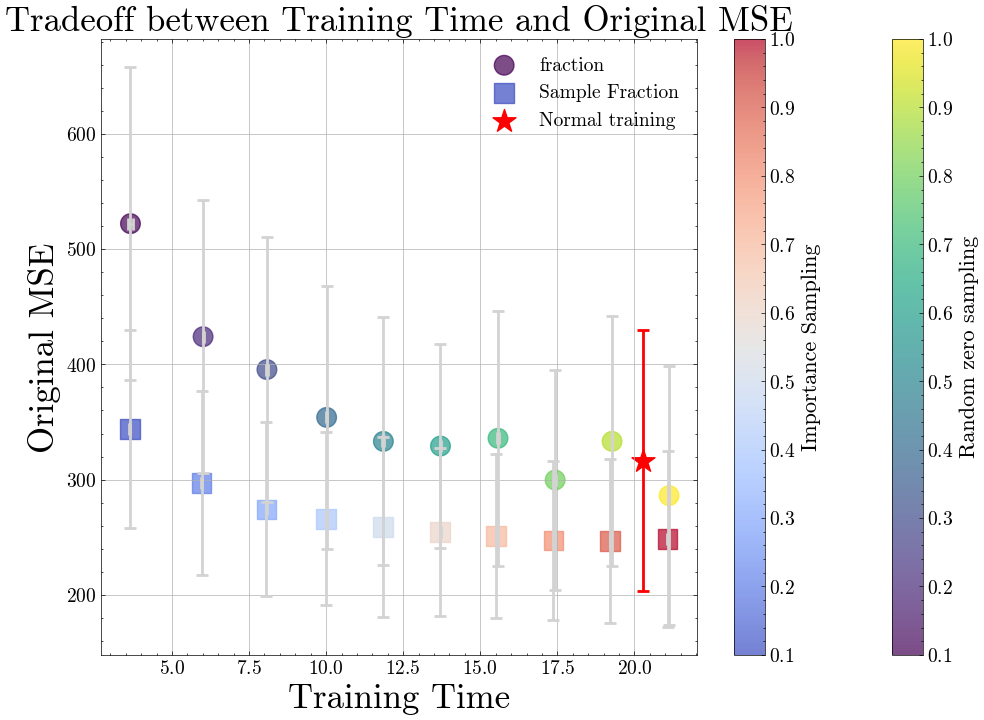

In [71]:
df1 = SIREN_random_2000_avg_data

# Second dataset
df2 = SIREN_importance_2000_avg_data

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for the first dataset with circle markers and error bars
scatter1 = plt.scatter(df1['training_time'], df1['original_mse'], 
                       c=df1['fraction'], cmap='viridis', s=200, alpha=0.7, label='fraction', marker='o')

# Adding error bars for the first dataset
plt.errorbar(df1['training_time'], df1['original_mse'], 
             xerr=df1['training_time_std'], yerr=df1['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Scatter plot for the second dataset with square markers and error bars
scatter2 = plt.scatter(df2['training_time'], df2['original_mse'], 
                       c=df2['sample_fraction'], cmap='coolwarm', s=200, alpha=0.7, label='Sample Fraction', marker='s')

# Adding error bars for the second dataset
plt.errorbar(df2['training_time'], df2['original_mse'], 
             xerr=df2['training_time_std'], yerr=df2['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Highlight a specific point with error bars
highlight_x = 20.262
highlight_y = 316.335
highlight_xerr = 0.007929  # Example standard deviation for training_time
highlight_yerr = 113.336801  # Example standard deviation for original_mse

plt.scatter(highlight_x, highlight_y, color='red', s=300, marker='*', label='Normal training')
plt.errorbar(highlight_x, highlight_y, 
             xerr=highlight_xerr, yerr=highlight_yerr,
             fmt='none', ecolor='red', elinewidth=2, capsize=4, capthick=2)

# Adding labels and title with larger font size
plt.xlabel('Training Time', fontsize=25)
plt.ylabel('Original MSE', fontsize=25)
plt.title('Tradeoff between Training Time and Original MSE', fontsize=25)

# Adding color bars with larger font size
cbar1 = plt.colorbar(scatter1)
cbar1.set_label('Random zero sampling', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

cbar2 = plt.colorbar(scatter2)
cbar2.set_label('Importance Sampling', fontsize=16)
cbar2.ax.tick_params(labelsize=14)

# Setting tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True)
plt.show()


In [60]:
SIREN_normal_same_avg_data

lr  hidden_features  hidden_layers  max_iters  outermost_linear  \
0  0.001              128              3       1000              True   

   hidden_omega_zero  first_omega_zero  original_mse  compression_ratio  \
0                 45               100    345.320421          22.721759   

   transformed_mse  training_time  original_psnr  model  original_mse_std  \
0         0.005456       10.15295      34.903715  SIREN         71.402019   

   training_time_std  
0            0.11407

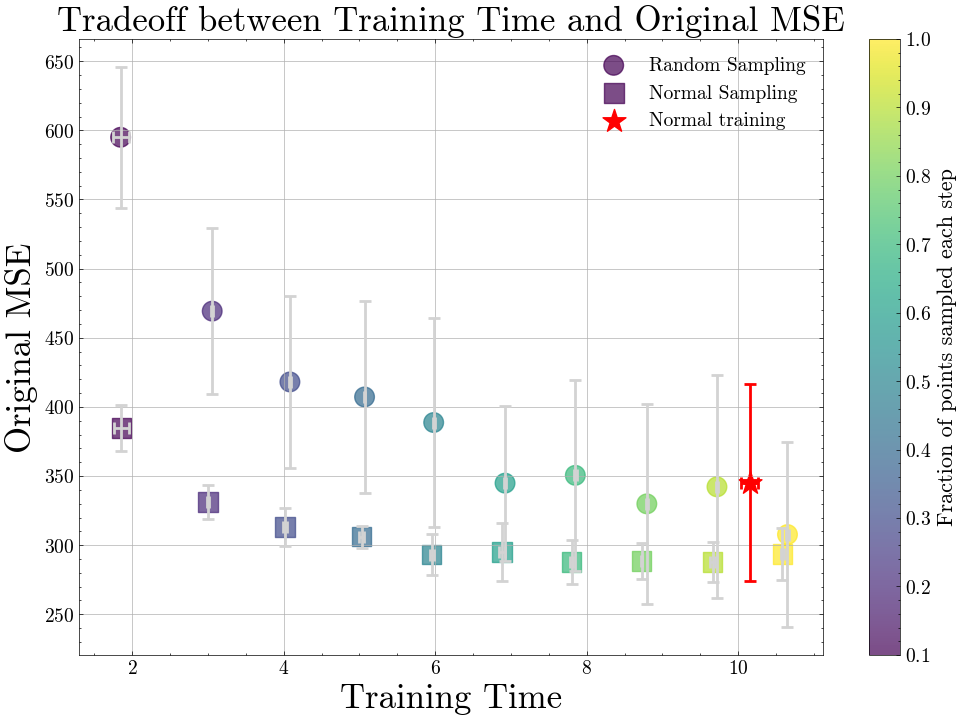

In [67]:
df1 = SIREN_random_same_avg_data

# Second dataset
df2 = SIREN_importance_same_avg_data

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for the first dataset with circle markers and error bars
scatter1 = plt.scatter(df1['training_time'], df1['original_mse'], 
                       c=df1['fraction'], cmap='viridis', s=200, alpha=0.7, label='Random Sampling', marker='o')

# Adding error bars for the first dataset
plt.errorbar(df1['training_time'], df1['original_mse'], 
             xerr=df1['training_time_std'], yerr=df1['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Scatter plot for the second dataset with square markers and error bars
scatter2 = plt.scatter(df2['training_time'], df2['original_mse'], 
                       c=df2['sample_fraction'], cmap='viridis', s=200, alpha=0.7, label='Normal Sampling', marker='s')

# Adding error bars for the second dataset
plt.errorbar(df2['training_time'], df2['original_mse'], 
             xerr=df2['training_time_std'], yerr=df2['original_mse_std'],
             fmt='none', ecolor='lightgray', elinewidth=2, capsize=4, capthick=2)

# Highlight a specific point with error bars
highlight_x = 10.15295
highlight_y = 345.32
highlight_xerr = 0.11  # Example standard deviation for training_time
highlight_yerr = 71.40  # Example standard deviation for original_mse

plt.scatter(highlight_x, highlight_y, color='red', s=300, marker='*', label='Normal training')
plt.errorbar(highlight_x, highlight_y, 
             xerr=highlight_xerr, yerr=highlight_yerr,
             fmt='none', ecolor='red', elinewidth=2, capsize=4, capthick=2)

# Adding labels and title with larger font size
plt.xlabel('Training Time', fontsize=25)
plt.ylabel('Original MSE', fontsize=25)
plt.title('Tradeoff between Training Time and Original MSE', fontsize=25)

# Adding color bars with larger font size
cbar1 = plt.colorbar(scatter1)
cbar1.set_label('Fraction of points sampled each step', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

# Setting tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True)
plt.show()


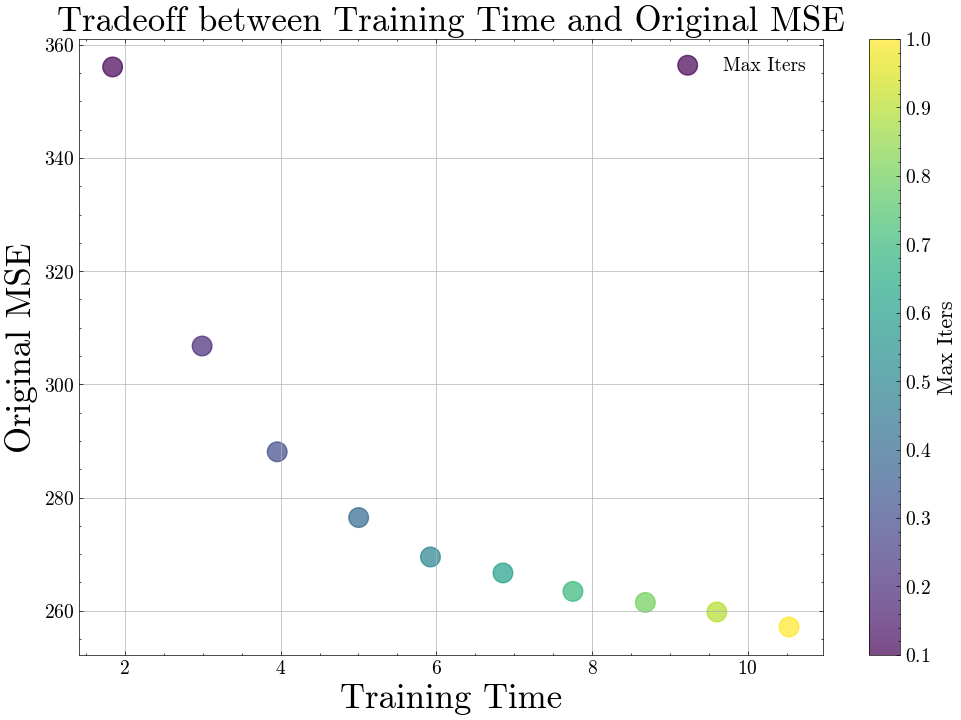

In [50]:
#importance sampling at different max_iters (all data)

df1 = SIREN_importance_avg_data

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot for the first dataset
scatter1 = plt.scatter(df1['training_time'], df1['original_mse'], 
                       c=df1['sample_fraction'], cmap='viridis', s=200, alpha=0.7, label='Max Iters', marker='o')


# Adding labels and title with larger font size
plt.xlabel('Training Time', fontsize=25)
plt.ylabel('Original MSE', fontsize=25)
plt.title('Tradeoff between Training Time and Original MSE', fontsize=25)

# Adding color bars with larger font size
cbar1 = plt.colorbar(scatter1)
cbar1.set_label('Max Iters', fontsize=16)
cbar1.ax.tick_params(labelsize=14)

# Setting tick parameters
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding legend
plt.legend(fontsize=14)

# Show plot
plt.grid(True)
plt.show()

In [26]:
data = np.load("../outer/12-2_0-0/AuAu200_170kHz_10C_Iter2_3001.xml_TPCMLDataInterface_0.npy")
data = data.astype(np.int16)

In [78]:
def plot_data(arr,title):
    # Create the figure
    fig = plt.figure(figsize=(12, 8))  # Adjusted width for a single plot
    
    # Create subplot for the array
    ax = fig.add_subplot(111, projection='3d')  # 111 means 1 row, 1 column, first subplot
    
    # Create meshgrid for plotting
    x, y = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))
    
    # Plot each layer for the array
    for i in range(arr.shape[2]):
        z = i * np.ones_like(x)
        c = arr[:,:,i]
        ax.plot_surface(x, y, z, facecolors=plt.cm.Reds(np.abs(c)), 
                        rstride=1, cstride=1, alpha=0.3, shade=False)
    
    # Set labels and title
    ax.set_xlabel('azimuthal', fontsize=14)
    ax.set_ylabel('z', fontsize=14)
    ax.set_zlabel('layer', fontsize=14)
    ax.set_title(title, fontsize=16)
    
    # Set axis limits
    ax.set_xlim(0, arr.shape[1])
    ax.set_ylim(0, arr.shape[0])
    ax.set_zlim(0, arr.shape[2])
    
    # Adjust the view angle
    ax.view_init(elev=20, azim=-45)
    
    plt.show()

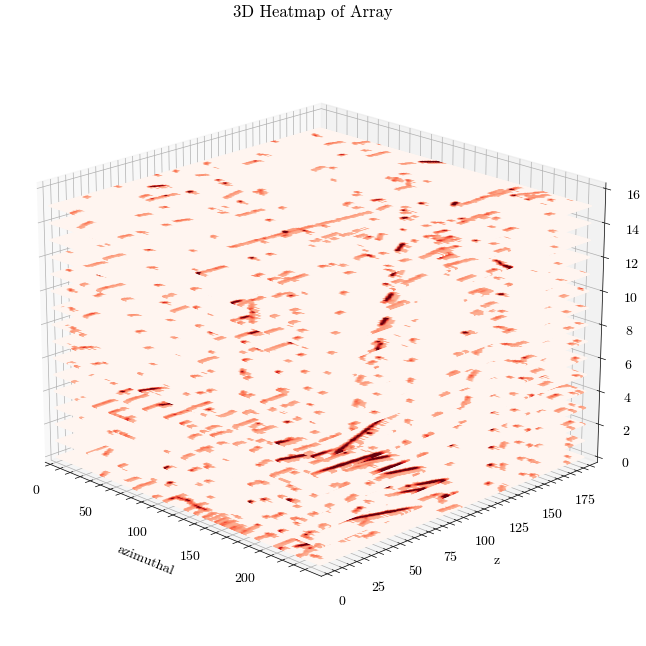

In [60]:
plot_data(data)

In [24]:
resolutions = pd.read_csv("final_data/resolution_tests.csv")
prediction_paths = "../grids/"+resolutions["prediction_path"]

In [25]:
paths = resolutions["prediction_path"].str.replace("_sample1", '', regex=False)
paths

0      saved_predictions/SIREN_grid(192, 249, 16).npy
1      saved_predictions/SIREN_grid(192, 125, 16).npy
2       saved_predictions/SIREN_grid(192, 249, 8).npy
3       saved_predictions/SIREN_grid(96, 125, 16).npy
4        saved_predictions/SIREN_grid(96, 125, 8).npy
5       saved_predictions/WIRE_grid(192, 249, 16).npy
6       saved_predictions/WIRE_grid(192, 125, 16).npy
7        saved_predictions/WIRE_grid(192, 249, 8).npy
8        saved_predictions/WIRE_grid(96, 125, 16).npy
9         saved_predictions/WIRE_grid(96, 125, 8).npy
10    saved_predictions/FFNet2_grid(192, 249, 16).npy
11    saved_predictions/FFNet2_grid(192, 125, 16).npy
12     saved_predictions/FFNet2_grid(192, 249, 8).npy
13     saved_predictions/FFNet2_grid(96, 125, 16).npy
14      saved_predictions/FFNet2_grid(96, 125, 8).npy
Name: prediction_path, dtype: object

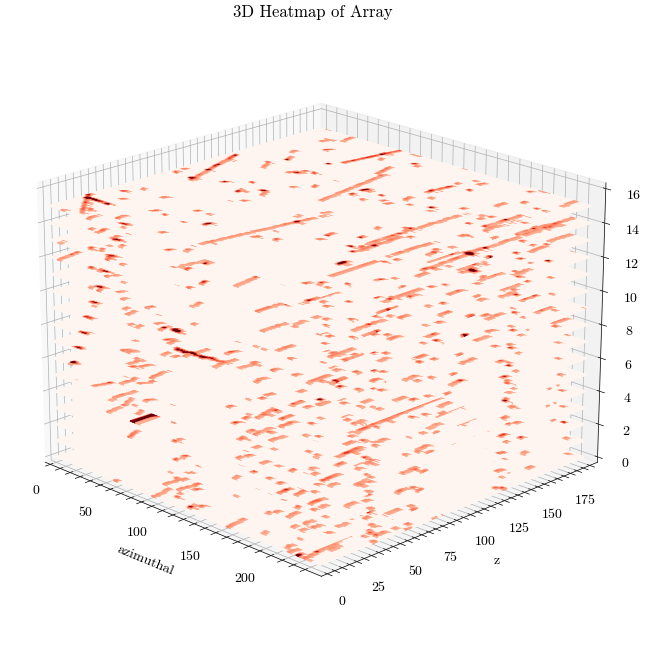

In [63]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data,"Original Data")

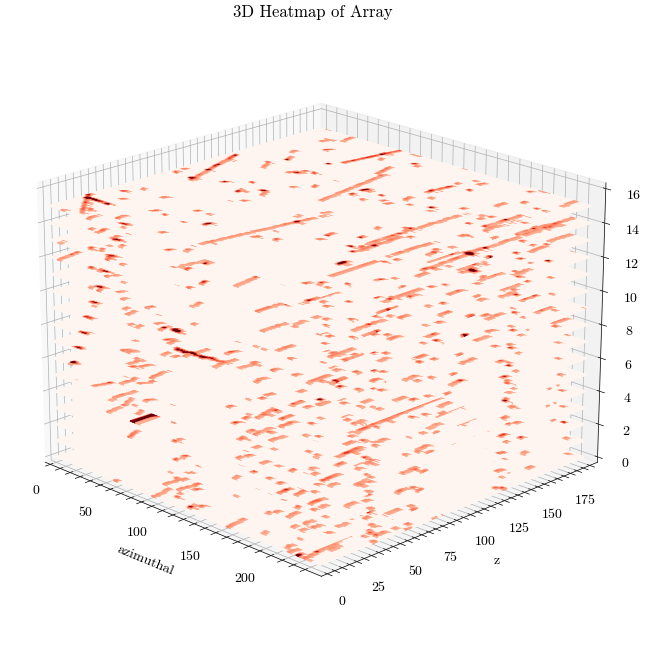

In [64]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data,"Data Models were trained on")

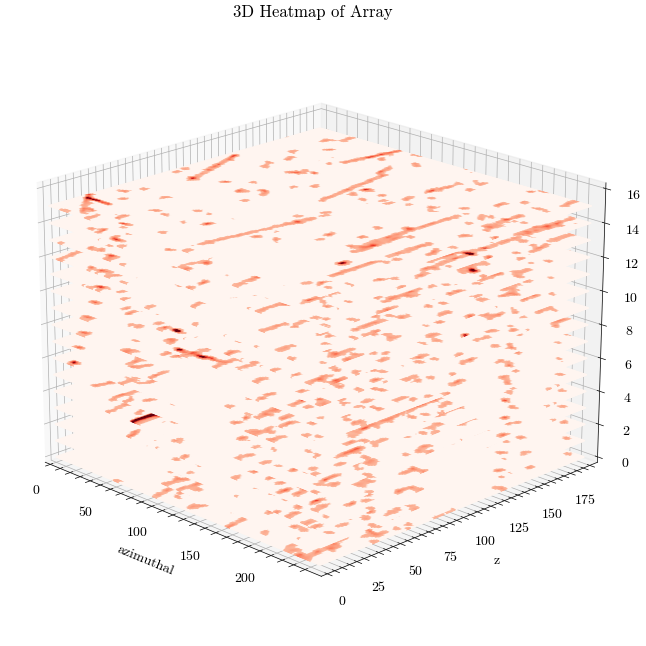

In [65]:
data = np.load("../grids/"+resolutions["prediction_path"][0])
plot_data(data,"SIREN output")

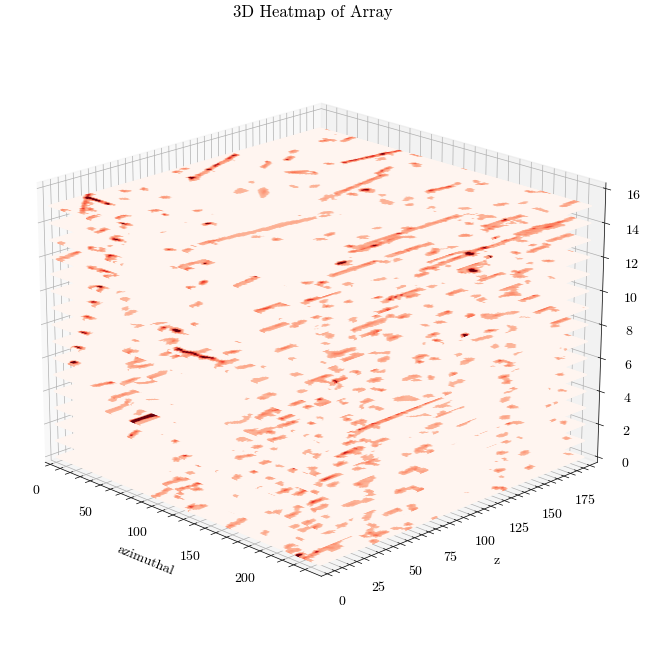

In [66]:
data = np.load("../grids/"+resolutions["prediction_path"][5])
plot_data(data,"WIRE output")

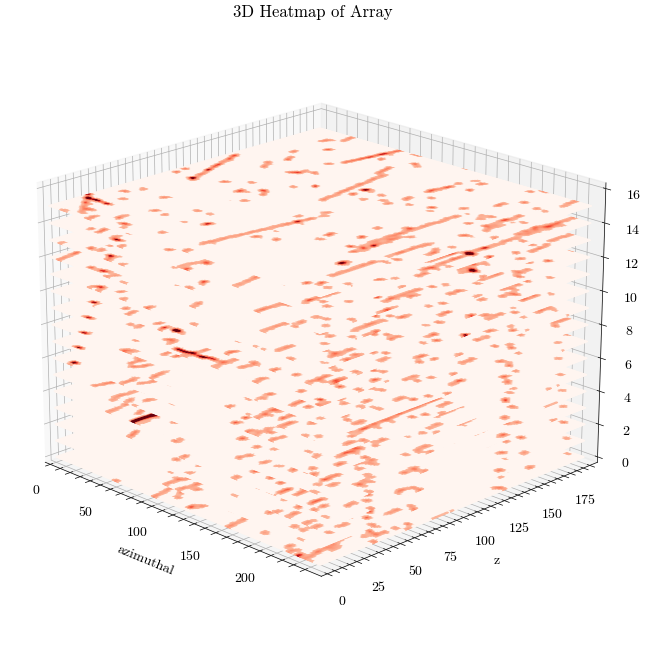

In [67]:
data = np.load("../grids/"+resolutions["prediction_path"][10])
plot_data(data,"FFN output")

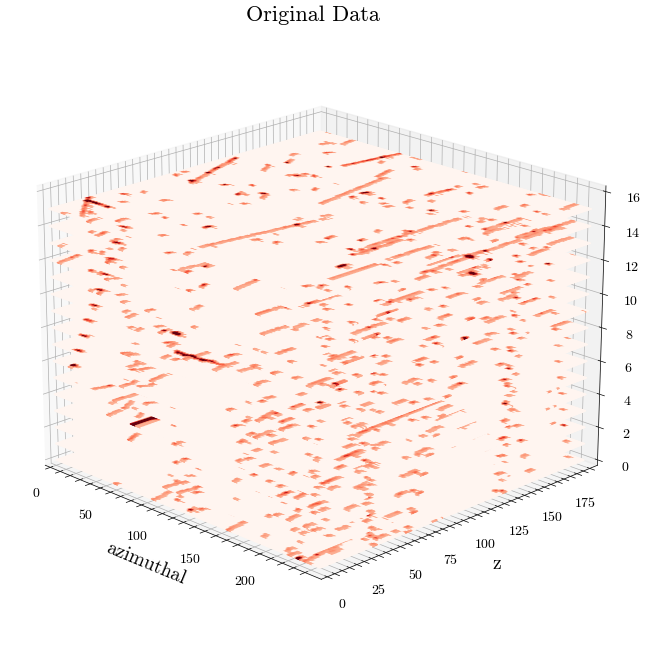

In [85]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data,"Original Data")

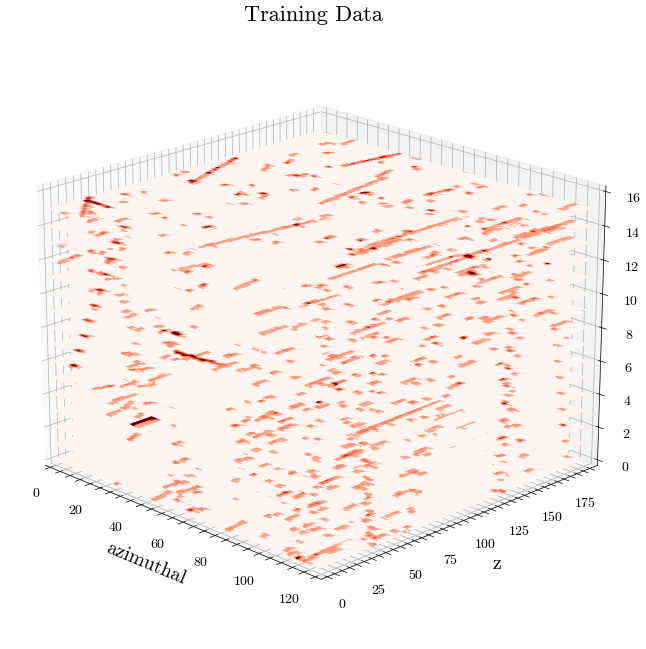

In [86]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
data = reshape_data(data,(192,125,16))
plot_data(data,"Training Data")

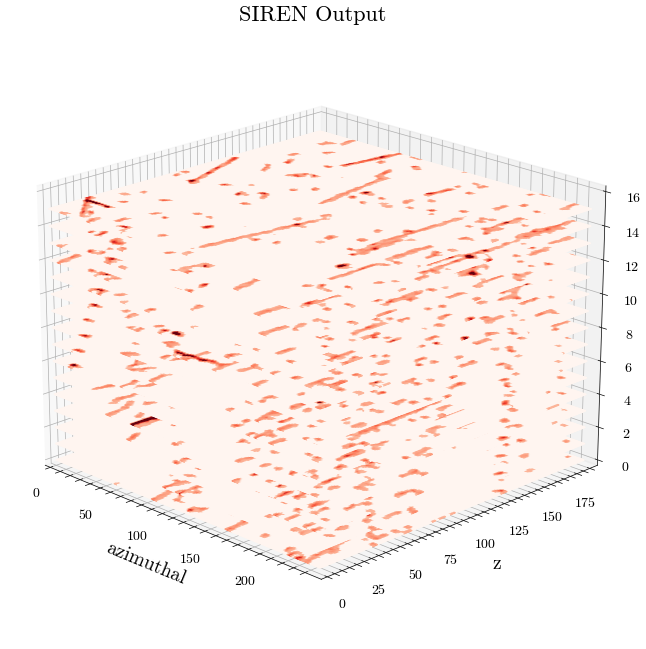

In [87]:
data = np.load("../grids/"+resolutions["prediction_path"][1])
plot_data(data,"SIREN Output")

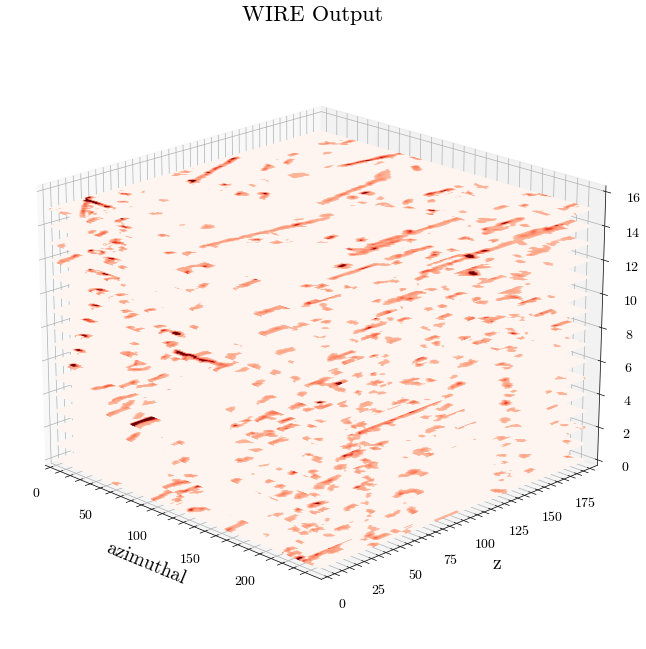

In [88]:
data = np.load("../grids/"+resolutions["prediction_path"][6])
plot_data(data,"WIRE Output")

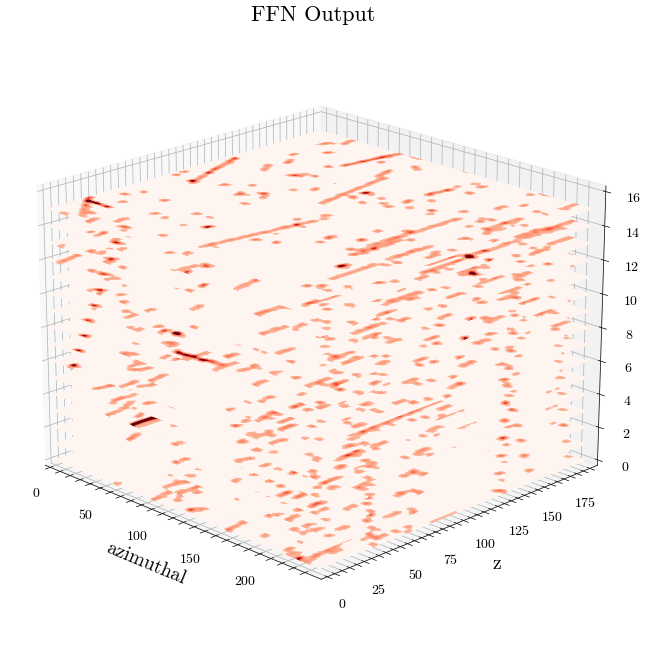

In [89]:
data = np.load("../grids/"+resolutions["prediction_path"][11])
plot_data(data,"FFN Output")

In [92]:
def plot_data_grid(data_list, row_names, col_names):
    # Create the figure
    fig = plt.figure(figsize=(30, 12))  # Increased figure size
    
    for idx, arr in enumerate(data_list):
        # Create subplot for each array
        ax = fig.add_subplot(2, 5, idx+1, projection='3d')
        
        # Create meshgrid for plotting
        x, y = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))
        
        # Plot each layer for the array
        for i in range(arr.shape[2]):
            z = i * np.ones_like(x)
            c = arr[:,:,i]
            ax.plot_surface(x, y, z, facecolors=plt.cm.Reds(np.abs(c)), 
                            rstride=1, cstride=1, alpha=0.3, shade=False)
        
        # Set labels and title with increased font size
        ax.set_xlabel('azimuthal', fontsize=14)
        ax.set_ylabel('z', fontsize=14)
        ax.set_zlabel('layer', fontsize=14)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Set axis limits
        ax.set_xlim(0, arr.shape[1])
        ax.set_ylim(0, arr.shape[0])
        ax.set_zlim(0, arr.shape[2])
        
        # Adjust the view angle
        ax.view_init(elev=20, azim=-45)
    
    # Set row and column labels with increased font size
    for i, row_name in enumerate(row_names):
        fig.text(0.04, 0.75 - i*0.5, row_name, rotation=90, va='center', fontsize=24, fontweight='bold')
    
    for i, col_name in enumerate(col_names):
        fig.text(0.1 + i*0.18, 0.98, col_name, ha='center', fontsize=24, fontweight='bold')
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])  # Adjust layout to accommodate larger labels
    plt.show()


data0 = np.load(resolutions["file_name"][0])
data0 = data0.astype(np.int16)

data1 = np.load(resolutions["file_name"][0])
data1 = data1.astype(np.int16)
data1 = reshape_data(data1,(192,125,16))

data2 = np.load("../grids/"+resolutions["prediction_path"][1])

data3 = np.load("../grids/"+resolutions["prediction_path"][6])

data4 = np.load("../grids/"+resolutions["prediction_path"][11])

data5 = np.load(resolutions["file_name"][0])
data5 = data5.astype(np.int16)

data6 = np.load(resolutions["file_name"][0])
data6 = data6.astype(np.int16)
data6 = reshape_data(data6,(192,249,8))

data7 = np.load("../grids/"+resolutions["prediction_path"][2])

data8 = np.load("../grids/"+resolutions["prediction_path"][7])

data9 = np.load("../grids/"+resolutions["prediction_path"][12])

data_list = [data0,data1,data2,data3,data4,data5,data6,data7,data8,data9]
row_names = ["(192,125,16)","(192,249,8)"]
column_names=["Original Data", "Training Data", "SIREN output", "WIRE output", "FFN output"]


In [ ]:
def plot_data_grid(data_list, row_names, col_names):
    # Create the figure
    fig = plt.figure(figsize=(30, 14))  # Increased height slightly
    
    # Create a grid of subplots
    gs = fig.add_gridspec(2, 5, left=0.05, right=0.98, top=0.85, bottom=0.08, hspace=0.3, wspace=0.15)
    
    for idx, arr in enumerate(data_list):
        row = idx // 5
        col = idx % 5
        
        # Create subplot for each array
        ax = fig.add_subplot(gs[row, col], projection='3d')
        
        # Create meshgrid for plotting
        x, y = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))
        
        # Plot each layer for the array
        for i in range(arr.shape[2]):
            z = i * np.ones_like(x)
            c = arr[:,:,i]
            ax.plot_surface(x, y, z, facecolors=plt.cm.Reds(np.abs(c)), 
                            rstride=1, cstride=1, alpha=0.3, shade=False)
        
        # Set labels and title with increased font size
        ax.set_xlabel('azimuthal', fontsize=12)
        ax.set_ylabel('z', fontsize=12)
        ax.set_zlabel('layer', fontsize=12)
        
        # Increase tick label font size
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        # Set axis limits
        ax.set_xlim(0, arr.shape[1])
        ax.set_ylim(0, arr.shape[0])
        ax.set_zlim(0, arr.shape[2])
        
        # Adjust the view angle
        ax.view_init(elev=20, azim=-45)
    
    # Set row labels
    for i, row_name in enumerate(row_names):
        fig.text(0.01, 0.75 - i*0.45, row_name, rotation=90, va='center', fontsize=24, fontweight='bold')
    
    # Set column labels
    for i, col_name in enumerate(col_names):
        ax = fig.add_subplot(gs[0, i])
        ax.text(0.5, 1.05, col_name, ha='center', va='bottom', fontsize=24, fontweight='bold', transform=ax.transAxes)
        ax.axis('off')
    
    plt.show()

plot_data_grid(data_list,row_names,column_names)

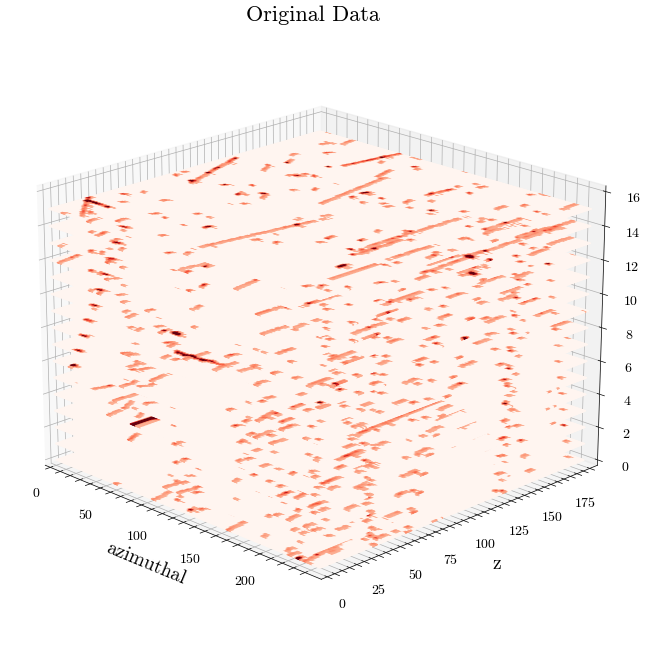

In [80]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data,"Original Data")

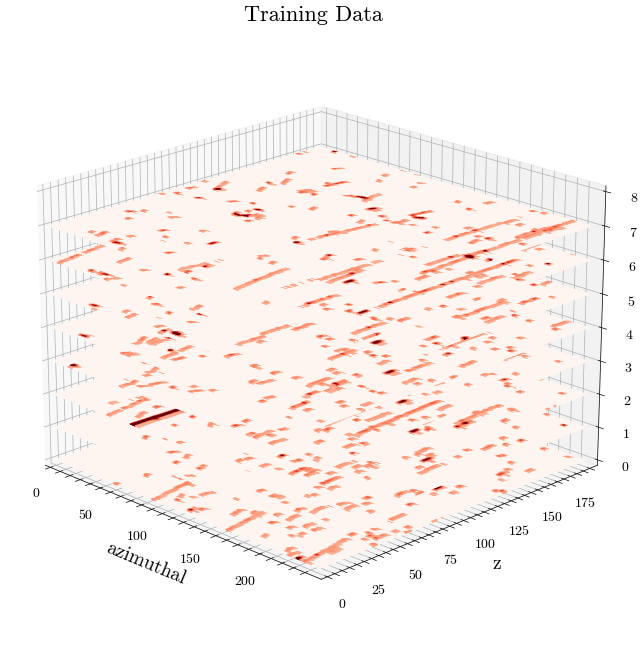

In [81]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
data = reshape_data(data,(192,249,8))
plot_data(data,"Training Data")

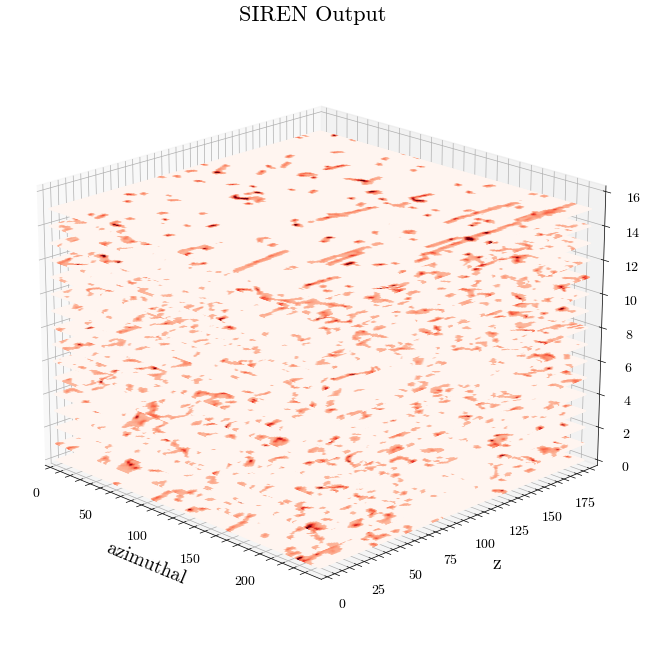

In [82]:
data = np.load("../grids/"+resolutions["prediction_path"][2])
plot_data(data,"SIREN Output")

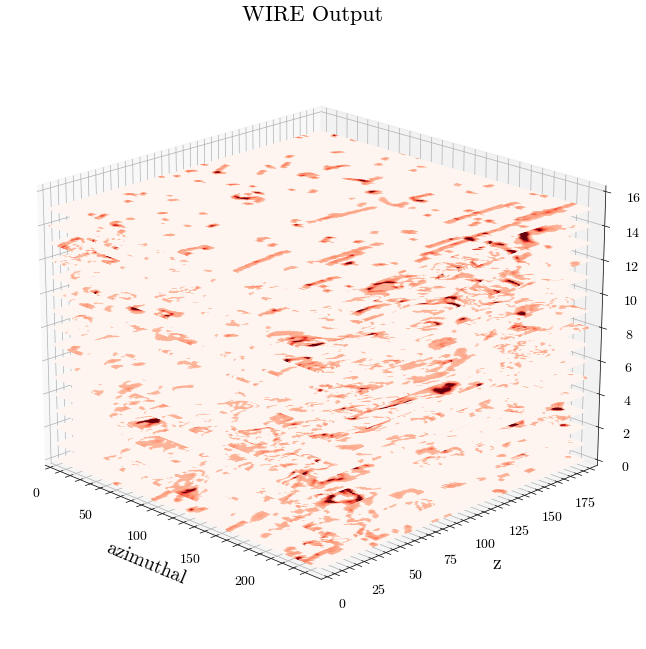

In [83]:
data = np.load("../grids/"+resolutions["prediction_path"][7])
plot_data(data,"WIRE Output")

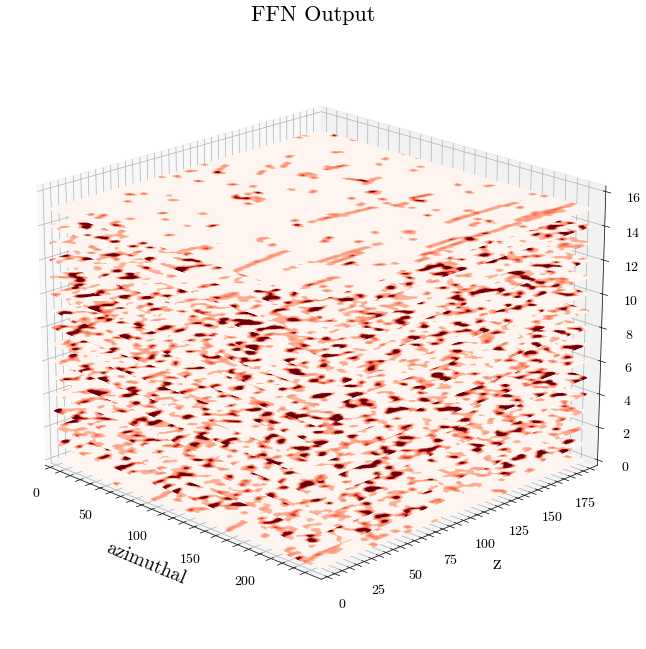

In [84]:
data = np.load("../grids/"+resolutions["prediction_path"][12])
plot_data(data,"FFN Output")

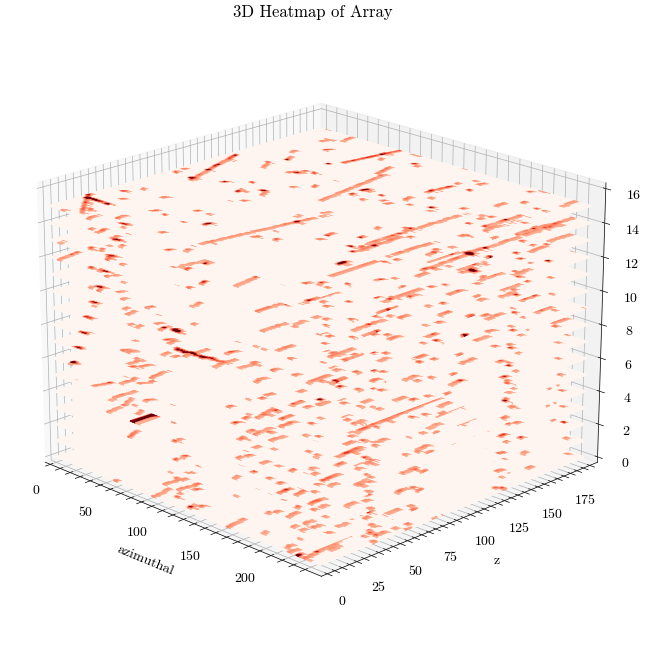

In [31]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data)

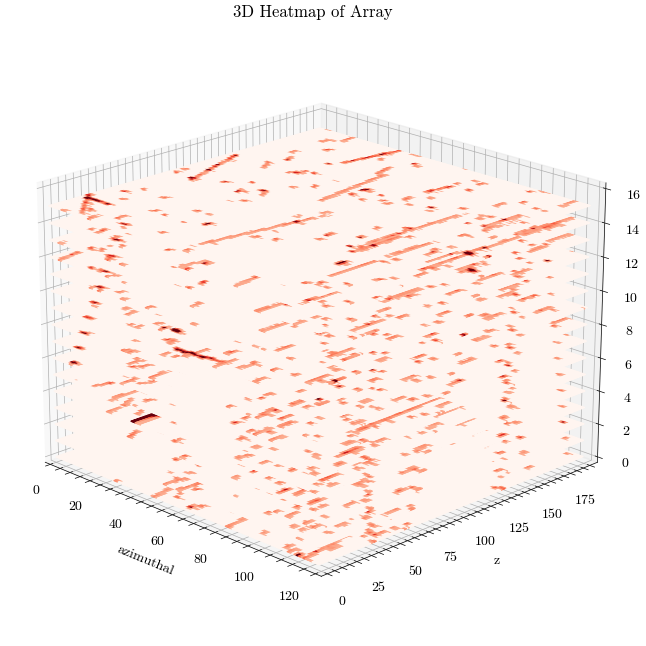

In [35]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
data = reshape_data(data,(192,125,16))
plot_data(data)

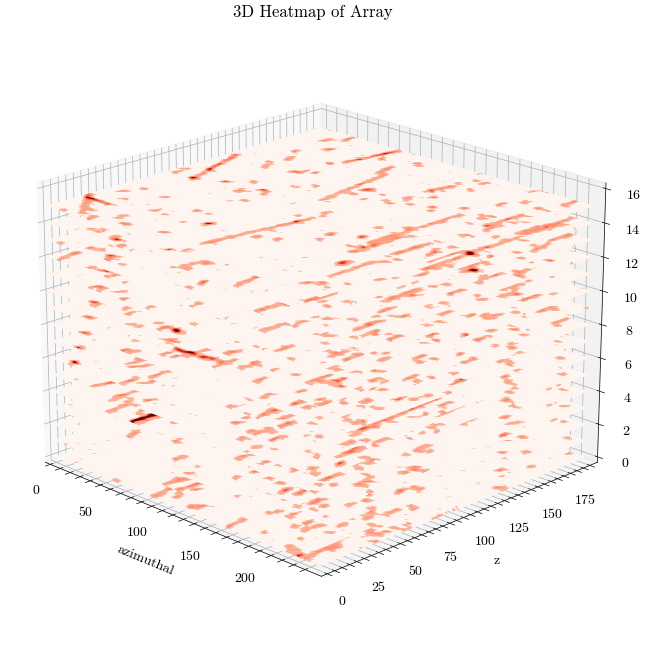

In [36]:
data = np.load("../grids/"+resolutions["prediction_path"][3])
plot_data(data)

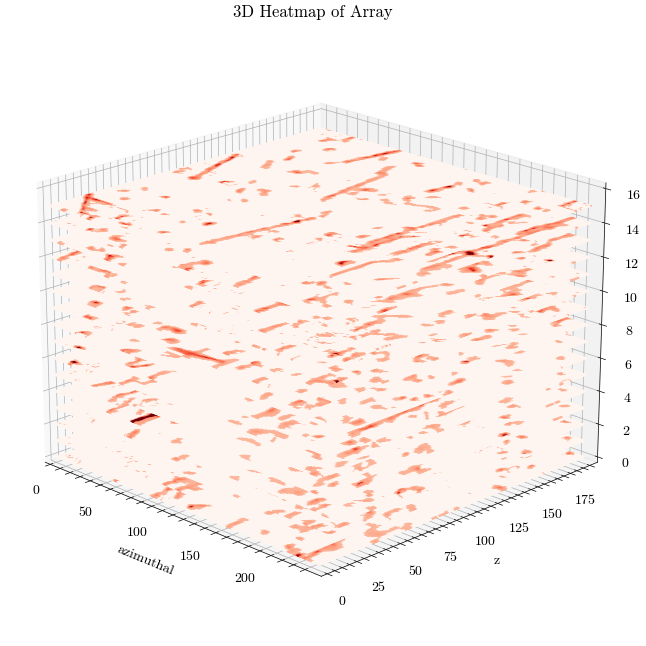

In [37]:
data = np.load("../grids/"+resolutions["prediction_path"][8])
plot_data(data)

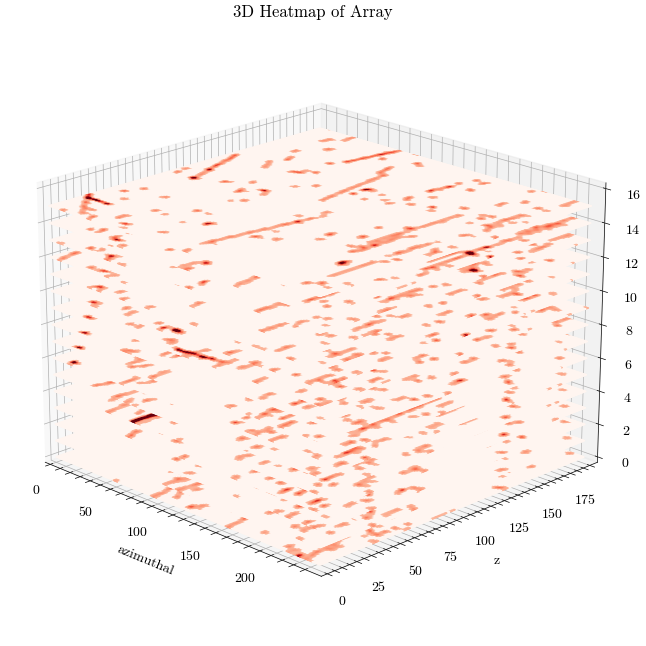

In [38]:
data = np.load("../grids/"+resolutions["prediction_path"][13])
plot_data(data)

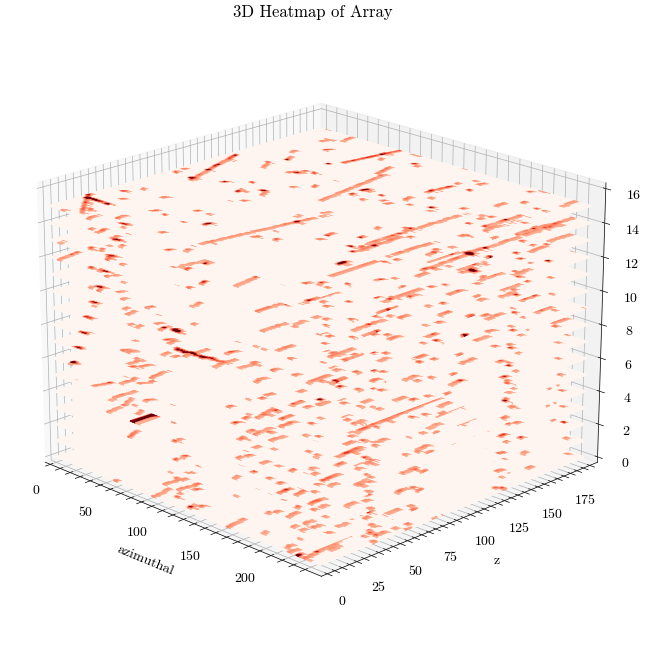

In [39]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
plot_data(data)

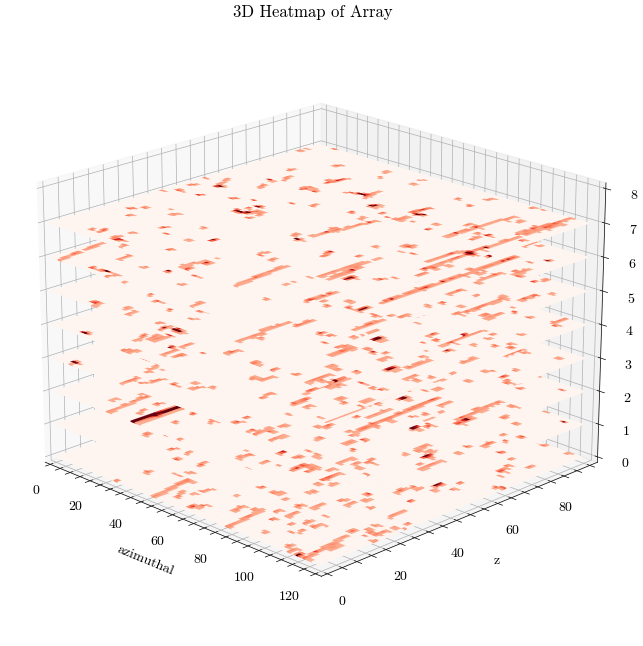

In [40]:
data = np.load(resolutions["file_name"][0])
data = data.astype(np.int16)
data = reshape_data(data,(96,125,8))
plot_data(data)

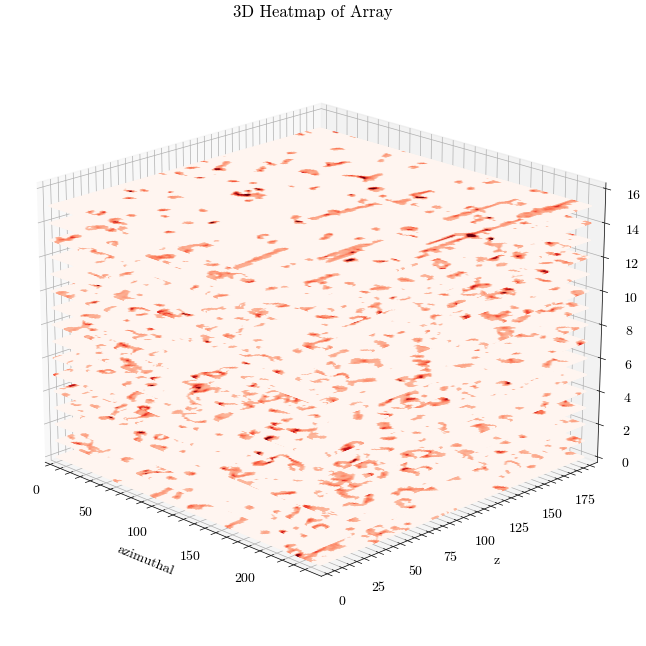

In [41]:
data = np.load("../grids/"+resolutions["prediction_path"][4])
plot_data(data)

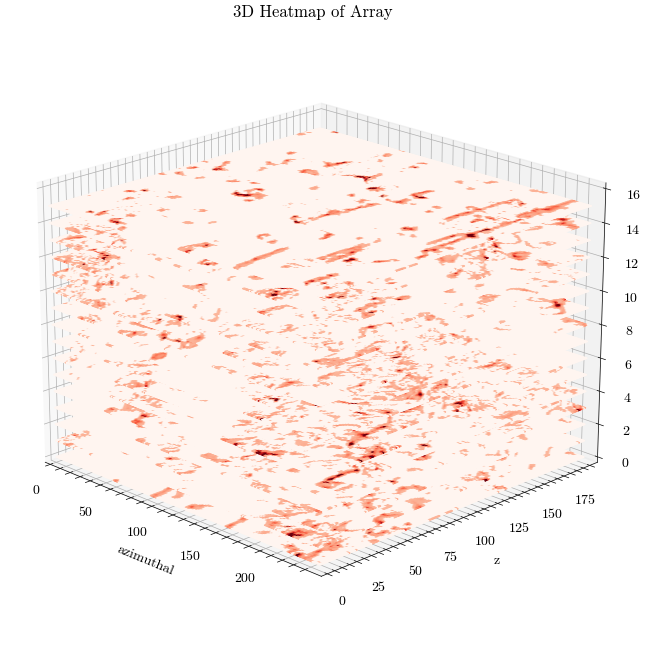

In [42]:
data = np.load("../grids/"+resolutions["prediction_path"][9])
plot_data(data)

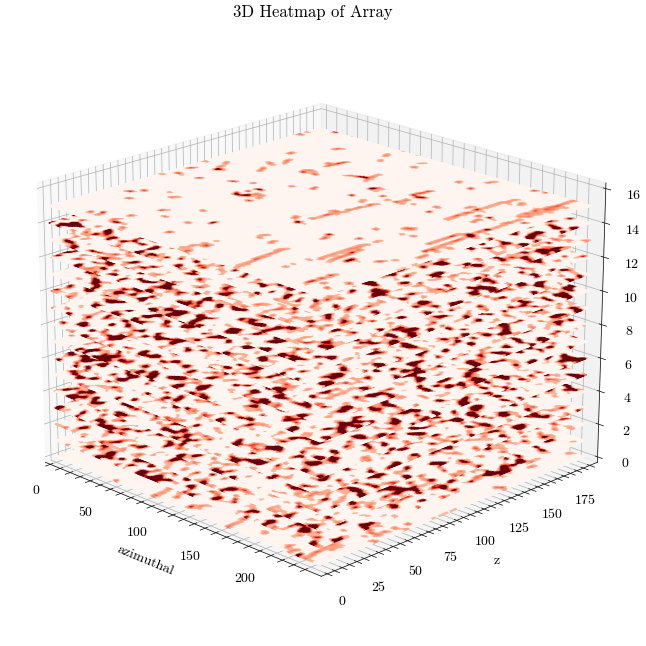

In [43]:
data = np.load("../grids/"+resolutions["prediction_path"][14])
plot_data(data)

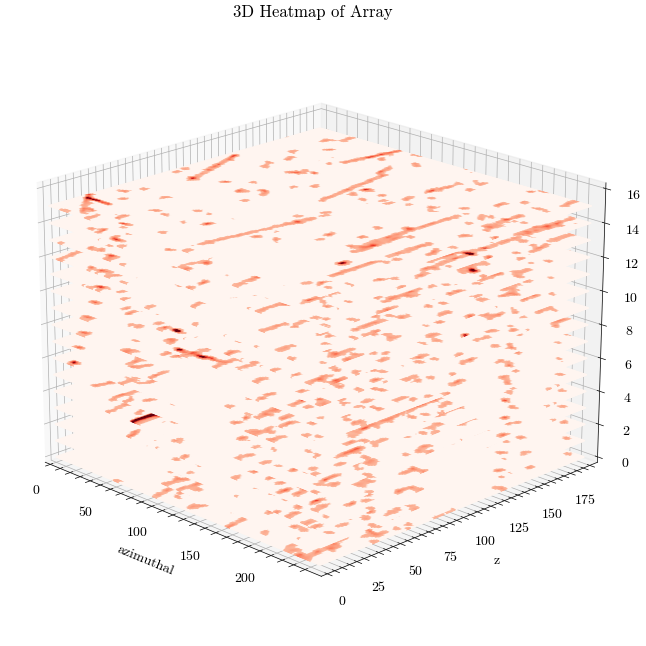

In [44]:
data = np.load("../grids/"+resolutions["prediction_path"][0])
plot_data(data)